In [1]:
import sys
sys.path.append('..')
%env CUDA_VISIBLE_DEVICES=0

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

import torch
import torch.nn as nn
import os
from collections import defaultdict

from torch.distributions import MultivariateNormal

from src.mrartemev_nflib.flows import NormalizingFlowModel, InvertiblePermutation, Invertible1x1Conv, ActNorm, NSF_AR
from src.mrartemev_nflib.flows import MAF, AffineHalfFlow
from src.mrartemev_nflib.nn import ARMLP, MLP

from torch.utils.data import Dataset, DataLoader, TensorDataset
from itertools import repeat

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

from src.nf import CalibratedModel, neg_log_likelihood
from src.nf.classifiers import train_catboost_clf
from scipy.special import logsumexp, expit


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

env: CUDA_VISIBLE_DEVICES=0


device(type='cuda')

In [2]:
class AffineHalfFlow(nn.Module):
    """
    As seen in RealNVP, affine autoregressive flow (z = x * exp(s) + t), where half of the
    dimensions in x are linearly scaled/transfromed as a function of the other half.
    Which half is which is determined by the parity bit.
    - RealNVP both scales and shifts (default)
    - NICE only shifts
    """

    def __init__(self, dim, base_network, scale=True, shift=True, **base_network_kwargs):
        super().__init__()
        self.dim = dim
        self.s_cond = lambda x, context: x.new_zeros(x.size(0), self.dim // 2, device=x.device)
        self.t_cond = lambda x, context: x.new_zeros(x.size(0), self.dim // 2, device=x.device)
        if scale:
            self.s_cond = base_network(self.dim - (self.dim // 2),
                                       self.dim // 2,
                                       **base_network_kwargs)
        if shift:
            self.t_cond = base_network(self.dim - (self.dim // 2),
                                       self.dim // 2,
                                       **base_network_kwargs)

    def forward(self, x, context=None):
        x0, x1 = x[:, ::2], x[:, 1::2]
        s = self.s_cond(x0, context=context)
        t = self.t_cond(x0, context=context)
        z1 = torch.exp(s) * x1 + t  # transform this half as a function of the other
        z = torch.cat([x0, z1], dim=1)
        log_det = torch.sum(s, dim=1)
        return z, log_det

    def inverse(self, z, context=None):
        k = z.shape[1] // 2 + z.shape[1] % 2
        z0, z1 = z[:, :k], z[:, k:]
        s = self.s_cond(z0, context)
        t = self.t_cond(z0, context)
        x1 = (z1 - t) * torch.exp(-s)  # reverse the transform on this half
        x = torch.empty_like(z)
        x[:, ::2] = z0
        x[:, 1::2] = x1
        log_det = torch.sum(-s, dim=1)
        return x, log_det

In [3]:
! ls dumps_20200602/GAS/SPLINE-AR_2_ind1

checkpoints  final_model.checkpoint


In [4]:
def fix_act_norm(layer):
    if isinstance(layer, ActNorm):
        layer.data_dep_init_done = True

In [5]:
def get_model(model_type, data, num_layers, dump_path):
    flows = []
    for _ in range(num_layers):
        if model_type == 'MAF':
            flows.append(MAF(dim=data.n_dims, base_network=ARMLP))
            flows.append(InvertiblePermutation(dim=data.n_dims))
        if model_type == 'SPLINE-AR':
            flows.append(ActNorm(dim=data.n_dims))
            flows.append(Invertible1x1Conv(dim=data.n_dims))
            flows.append(NSF_AR(dim=data.n_dims, K=8, B=3, hidden_features=32, depth=1, base_network=MLP))
        if model_type == 'GLOW':
            flows.append(ActNorm(dim=data.n_dims))
            flows.append(Invertible1x1Conv(dim=data.n_dims))
            flows.append(AffineHalfFlow(dim=data.n_dims, hidden_features=32, base_network=MLP))
            flows.append(InvertiblePermutation(dim=data.n_dims))
        if model_type == 'RealNVP':
            flows.append(AffineHalfFlow(dim=data.n_dims, base_network=MLP))
            flows.append(InvertiblePermutation(dim=data.n_dims))

    lr = 0.0005

    prior = MultivariateNormal(torch.zeros(data.n_dims).to(device), torch.eye(data.n_dims).to(device))
    model = NormalizingFlowModel(prior, flows).to(device)
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    checkpoint = torch.load(dump_path)
    model.load_state_dict(checkpoint['model.state_dict()'])
    model.apply(fix_act_norm)
    
    return model

In [6]:
def to_device(model, device):
    model.to(device)
    model.prior = MultivariateNormal(torch.zeros(data.n_dims).to(device),
                                     torch.eye(data.n_dims).to(device))

In [7]:
def repeater(data_loader):
    for loader in repeat(data_loader):
        for data in loader:
            yield data

In [8]:
def batched_sample(model, n, batch_size=14000):
    generated = []
    for _ in range(n // batch_size):
        generated_batch = model.sample(batch_size)
        generated.append(generated_batch.cpu().detach())
    if n % batch_size != 0:
        generated_batch = model.sample(n % batch_size)
        generated.append(generated_batch.cpu().detach())
    generated = torch.cat(generated, dim=0)
    assert n == len(generated)
    return generated

In [9]:
def logloss_with_logits(y_pred_logits, y_true):
    return -np.mean(
        y_true * np.logaddexp(0, -y_pred_logits) + \
        (1 - y_true) * np.logaddexp(0, y_pred_logits)
    )

In [10]:
# def train_cb(model, X_train_tensor, X_test_tensor, clips, iters):
#     clf_ds_train = np.row_stack([
#         np.column_stack([X_train_tensor.cpu().detach().numpy(), np.ones(len(X_train_tensor)).reshape(-1, 1)]),
#         np.column_stack([model.sample_n(len(X_train_tensor)).cpu().detach().numpy(), np.zeros(len(X_train_tensor)).reshape(-1, 1)])
#     ]).astype(np.float32)

#     clf_ds_test = np.row_stack([
#         np.column_stack([X_test_tensor.cpu().detach().numpy(), np.ones(len(X_test_tensor)).reshape(-1, 1)]),
#         np.column_stack([model.sample_n(len(X_test_tensor)).cpu().detach().numpy(), np.zeros(len(X_test_tensor)).reshape(-1, 1)])
#     ]).astype(np.float32)

#     samples = model.sample_n(n).cpu().detach().cpu().numpy()
    

#     metrics = []
#     for n_iters in iters:
#         clf = CatBoostClassifier(n_iters, verbose=0).fit(
#             clf_ds_train[:, :-1], clf_ds_train[:, -1],
#         )
#         for clip in clips:
#             calibrated_model = CalibratedModel(
#                 lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, clip),
#                 model,
#                 logit=True
#             )
#             clf_preds = np.clip(clf.predict(samples, prediction_type='RawFormulaVal'), -100, np.log(clip))
#             calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
#             logits = clf_preds - calibration_constant
#             ll = -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant
#             auc_roc = roc_auc_score(
#                 clf_ds_test[:, -1],
#                 np.clip(clf.predict(clf_ds_test[:, :-1], prediction_type='RawFormulaVal'), -100, np.log(clip)),
#             )
#             log_loss = logloss_with_logits(
#                 np.clip(clf.predict(clf_ds_test[:, :-1], prediction_type='RawFormulaVal'), -100, np.log(clip)),
#                 clf_ds_test[:, -1]
#             )
#             metrics.append({
#                 'clip': clip,
#                 'iters': n_iters,
#                 'll': ll,
#                 'auc_roc': auc_roc,
#                 'logloss': log_loss,
#                 'overhead': np.max(logits),
#                 'calibration_constant': calibration_constant
#             })

#     return clf_ds_train, clf_ds_test, metrics

In [21]:
def train_cb(model, X_train_tensor, X_test_tensor, clips, iters):
    clf_ds_train = np.row_stack([
        np.column_stack([X_train_tensor.cpu().detach().numpy(), np.ones(len(X_train_tensor)).reshape(-1, 1)]),
        np.column_stack([model.sample_n(len(X_train_tensor)).cpu().detach().numpy(), np.zeros(len(X_train_tensor)).reshape(-1, 1)])
    ]).astype(np.float32)

    clf_ds_test = np.row_stack([
        np.column_stack([X_test_tensor.cpu().detach().numpy(), np.ones(len(X_test_tensor)).reshape(-1, 1)]),
        np.column_stack([model.sample_n(len(X_test_tensor)).cpu().detach().numpy(), np.zeros(len(X_test_tensor)).reshape(-1, 1)])
    ]).astype(np.float32)

    samples = model.sample_n(n).cpu().detach().cpu().numpy()
    
    metrics = []
    for n_iters in iters:
        clf = CatBoostClassifier(n_iters, verbose=0).fit(
            clf_ds_train[:, :-1], clf_ds_train[:, -1],
        )
        for clip in clips:
            clf_wrap = lambda x: np.clip(clf.predict(x, prediction_type='RawFormulaVal'), -100, np.log(clip))
            calibrated_model = CalibratedModel(
                clf_wrap,
                model,
                logit=True
            )
            clf_preds = clf_wrap(samples)
            assert np.all(clf_preds <= np.log(clip))
            calibration_constant = logsumexp(clf_preds) - np.log(len(clf_preds))
            logits = clf_preds - calibration_constant
            ll = -neg_log_likelihood(calibrated_model, X_test_tensor.cpu().detach()) - calibration_constant
            
            assert np.all(clf_wrap(clf_ds_test[:, :-1]) <= np.log(clip))
            auc_roc = roc_auc_score(
                clf_ds_test[:, -1],
                clf_wrap(clf_ds_test[:, :-1]),
            )
            log_loss = logloss_with_logits(
                clf_wrap(clf_ds_test[:, :-1]),
                clf_ds_test[:, -1]
            )
            metrics.append({
                'clip': clip,
                'iters': n_iters,
                'll': ll,
                'auc_roc': auc_roc,
                'logloss': log_loss,
                'overhead': np.max(logits),
                'calibration_constant': calibration_constant
            })

    return clf_ds_train, clf_ds_test, metrics

In [22]:
from utils import data_utils

data_mapping = {'BSDS300': data_utils.BSDS300,
                'GAS': data_utils.GAS,
                'MINIBOONE': data_utils.MINIBOONE,
                'POWER': data_utils.POWER,
                'HEPMASS': data_utils.HEPMASS}

In [23]:
def get_best_model(model_type, data, num_layers, dumps_path):
    best_ll, best_model, best_dump = -10000000, None, None
    X_test_tensor = torch.from_numpy(data.tst.x[:100000]).to(device)
    
    for dump_path in [dumps_path + '/final_model.checkpoint'] + [
        os.path.join(dumps_path, 'checkpoints', path) for path in os.listdir(dumps_path + '/checkpoints')
    ]:
        try:
            model = get_model(model_type, data, num_layers, dump_path)
        except FileNotFoundError:
            print(f'Not found {dump_path}')
            continue
        ll = -neg_log_likelihood(model, X_test_tensor)
        if ll > best_ll:
            best_ll = ll
            best_model = model
            best_dump = dump_path
    return best_model, best_ll, best_dump

In [24]:
arr = []
for data_name in ('MINIBOONE', 'BSDS300', 'GAS', 'HEPMASS', 'POWER'):
    data = data_mapping[data_name]()
    dim = data.n_dims
    n = min(100000, data.trn.x.shape[0])
    X_train_tensor = torch.from_numpy(data.trn.x[:n]).to(device)
    X_test_tensor = torch.from_numpy(data.tst.x[:n]).to(device)

    for model_type in ('GLOW', 'MAF', 'RealNVP', 'SPLINE-AR'):
        num_layers = 2 if model_type == 'SPLINE-AR' else 5
        model_name = f"{model_type}_{num_layers}"

        dumps_path = f'dumps_20200602/{data_name}/{model_type}_{num_layers}_ind1'
        model, ll, dump_path = get_best_model(model_type, data, num_layers, dumps_path)
        
        model.eval()
        model.sample_n = lambda n: batched_sample(model, n)
        to_device(model, 'cpu')

        clf_ds_train, clf_ds_test, metrics = train_cb(model, X_train_tensor, X_test_tensor, [10000, 2, 1.5], [1, 20, 100, 500, 1000, 5000])
        
        arr.append({
            'data_name': data_name,
            'model_type': model_type,
            'll': ll,
            'metrics': metrics,
            'dump_path': dump_path,
        })
        print(data_name, model_type, ll, [x['ll'] for x in metrics])
#         print(arr[-1])

MINIBOONE GLOW -14.054896354675293 [-13.415775897453912, -13.717810491465443, -13.745627991106145, -12.95648144230692, -13.41823962134589, -13.488947255194466, -12.662769531199304, -13.305623419569471, -13.378416334202635, -12.639665218751599, -13.263415131652316, -13.348235922012217, -12.629128650306082, -13.257350205366794, -13.342239887852427, -12.592408975617488, -13.23907209627001, -13.325925130165565]
MINIBOONE MAF -12.341054916381836 [-12.036867150381692, -12.078799371660896, -12.107010562333107, -11.325887898326876, -11.785294878081086, -11.844394054041846, -11.017441867211351, -11.688143116689293, -11.749058790588268, -11.0068241257355, -11.63307992785128, -11.709889440867189, -10.991329216071547, -11.62563952999237, -11.703377339879204, -10.971616169912723, -11.607680446226535, -11.687245518284794]
MINIBOONE RealNVP -13.369071960449219 [-12.983775102954485, -13.06284654071672, -13.094369381433992, -12.158998838271618, -12.70057444164326, -12.771381330034867, -11.8493083728593

In [25]:
[x['dump_path'] for x in arr]

['dumps_20200602/MINIBOONE/GLOW_5_ind1/checkpoints/50000.checkpoint',
 'dumps_20200602/MINIBOONE/MAF_5_ind1/final_model.checkpoint',
 'dumps_20200602/MINIBOONE/RealNVP_5_ind1/checkpoints/100000.checkpoint',
 'dumps_20200602/MINIBOONE/SPLINE-AR_2_ind1/checkpoints/50000.checkpoint',
 'dumps_20200602/BSDS300/GLOW_5_ind1/final_model.checkpoint',
 'dumps_20200602/BSDS300/MAF_5_ind1/final_model.checkpoint',
 'dumps_20200602/BSDS300/RealNVP_5_ind1/final_model.checkpoint',
 'dumps_20200602/BSDS300/SPLINE-AR_2_ind1/checkpoints/200000.checkpoint',
 'dumps_20200602/GAS/GLOW_5_ind1/final_model.checkpoint',
 'dumps_20200602/GAS/MAF_5_ind1/final_model.checkpoint',
 'dumps_20200602/GAS/RealNVP_5_ind1/final_model.checkpoint',
 'dumps_20200602/GAS/SPLINE-AR_2_ind1/final_model.checkpoint',
 'dumps_20200602/HEPMASS/GLOW_5_ind1/final_model.checkpoint',
 'dumps_20200602/HEPMASS/MAF_5_ind1/final_model.checkpoint',
 'dumps_20200602/HEPMASS/RealNVP_5_ind1/final_model.checkpoint',
 'dumps_20200602/HEPMASS/SPLI

In [26]:
metrics = defaultdict(dict)
for x in arr:
    model_name = (x['model_type'], 'normalizing flow', '', '', )
    metrics[(x['data_name'], 'll', )][model_name] = x['ll']
    metrics[(x['data_name'], 'log overhead', )][model_name] = 0
    for y in x['metrics']:
        if y['clip'] == 10000:
            model_name = (x['model_type'], 'calibrated', y['iters'], 'inf', )
        else:
            model_name = (x['model_type'], 'calibrated', y['iters'], str(round(y['clip'], 2)), )
        metrics[(x['data_name'], 'll', )][model_name] = y['ll']
        metrics[(x['data_name'], 'log overhead', )][model_name] = y['overhead']
        metrics[(x['data_name'], 'AUC-ROC', )][model_name] = y['auc_roc']
        metrics[(x['data_name'], 'Logloss', )][model_name] = -y['logloss']
metrics = pd.DataFrame(metrics)
pd.set_option('display.max_rows', metrics.shape[0] + 1)
metrics

MINIBOONE                         \
                                            ll log overhead   AUC-ROC   
GLOW      calibrated       1    1.5 -13.745628     0.580708  0.690873   
                                2   -13.717810     0.868369  0.690873   
                                inf -13.415776     3.798131  0.690873   
                           20   1.5 -13.488947     0.782618  0.808105   
                                2   -13.418240     0.999863  0.818251   
                                inf -12.956481     3.481170  0.824899   
                           100  1.5 -13.378416     0.891791  0.826496   
                                2   -13.305623     1.082761  0.837144   
                                inf -12.662770     4.997682  0.849253   
                           500  1.5 -13.348236     0.896565  0.842633   
                                2   -13.263415     1.096708  0.853900   
                                inf -12.639665     3.779463  0.864857   
                           1000 1.5 -13.342240     0.900939  0.842928   
                                2   -13.257350     1.103191  0.853922   
                                inf -12.629129     3.905379  0.864511   
                           5000 1.5 -13.325925     0.912956  0.847739   
                                2   -13.239072     1.113907  0.858201   
                                inf -12.592409     3.866771  0.869313   
          normalizing flow          -14.054896     0.000000       NaN   
MAF       calibrated       1    1.5 -12.107011     0.548128  0.664758   
                                2   -12.078799     0.827746  0.664758   
                                inf -12.036867     2.594691  0.664738   
                           20   1.5 -11.844394     0.736757  0.783722   
                                2   -11.785295     0.963257  0.793732   
                                inf -11.325888     3.511395  0.799633   
                           100  1.5 -11.749059     0.841391  0.804011   
                                2   -11.688143     1.038192  0.815805   
                                inf -11.017442     5.487612  0.826024   
                           500  1.5 -11.709889     0.843725  0.825439   
                                2   -11.633080     1.056831  0.835881   
                                inf -11.006824     4.157483  0.843966   
                           1000 1.5 -11.703377     0.848774  0.828154   
                                2   -11.625640     1.061602  0.839564   
                                inf -10.991329     4.355156  0.847685   
                           5000 1.5 -11.687246     0.862240  0.831142   
                                2   -11.607680     1.074852  0.842310   
                                inf -10.971616     4.134255  0.850880   
          normalizing flow          -12.341055     0.000000       NaN   
RealNVP   calibrated       1    1.5 -13.094369     0.574311  0.698670   
                                2   -13.062847     0.857477  0.698670   
                                inf -12.983775     1.803474  0.698717   
                           20   1.5 -12.771381     0.824863  0.812890   
                                2   -12.700574     1.033334  0.823815   
                                inf -12.158999     4.569587  0.832711   
                           100  1.5 -12.667108     0.926712  0.830765   
                                2   -12.596992     1.112026  0.841868   
                                inf -11.849308     5.243650  0.855206   
                           500  1.5 -12.642006     0.926134  0.845515   
                                2   -12.560231     1.120502  0.856198   
                                inf -11.881628     4.617398  0.867157   
                           1000 1.5 -12.633445     0.931110  0.846957   
                                2   -12.550524     1.127104  0.856439   
                                inf -11.860532     4.743502  0.868427   
                      

mkdir: cannot create directory ‘plots’: File exists


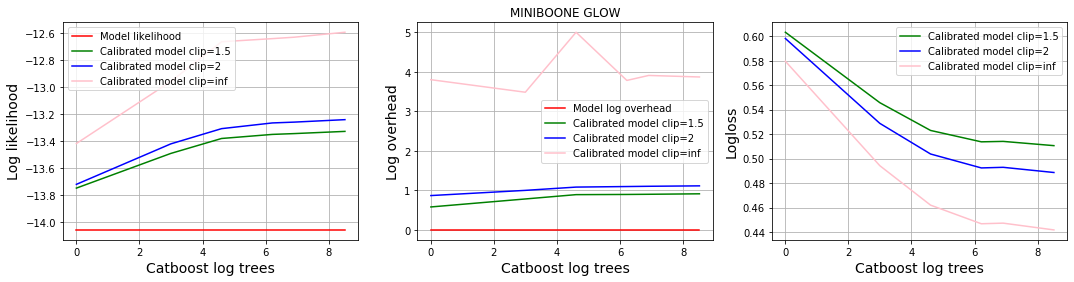

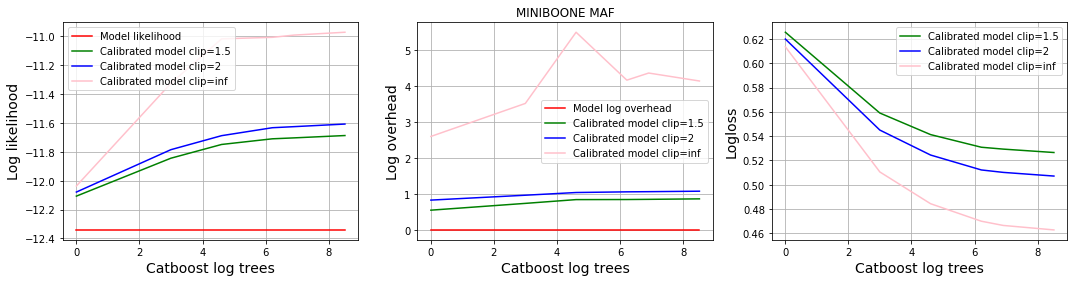

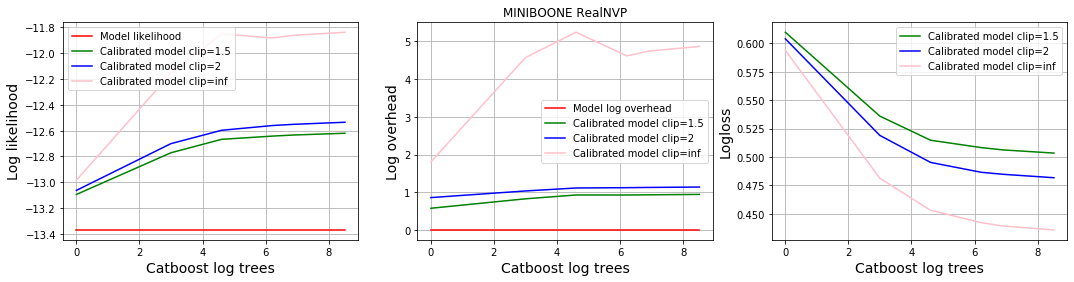

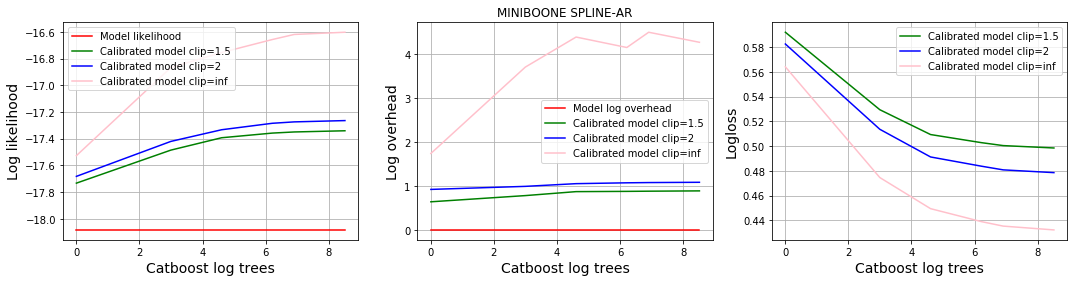

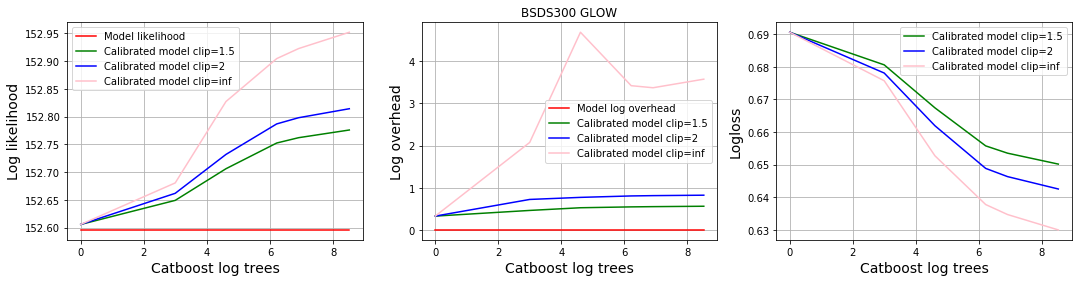

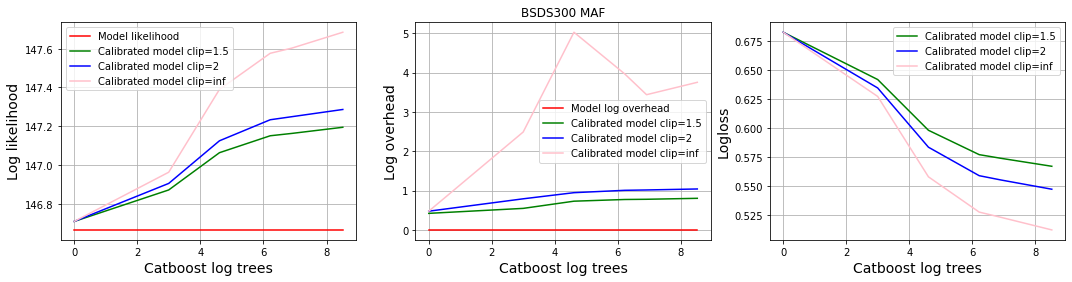

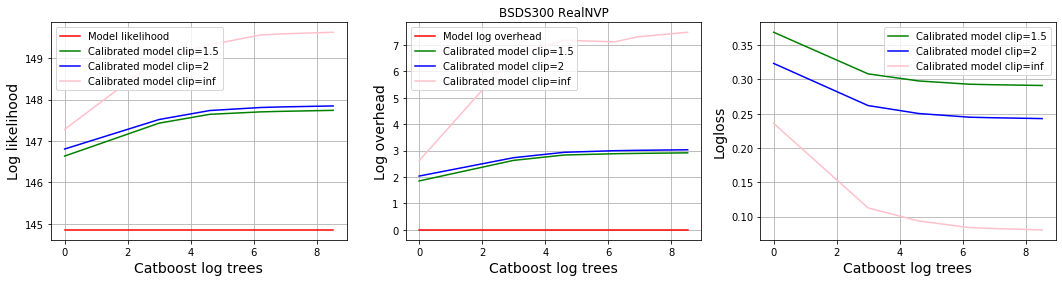

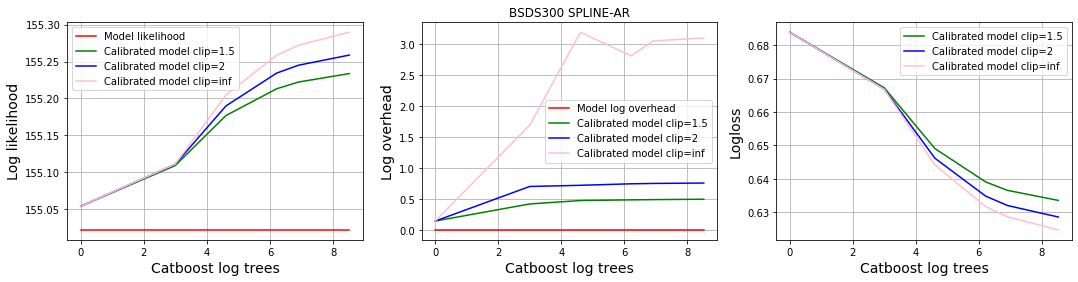

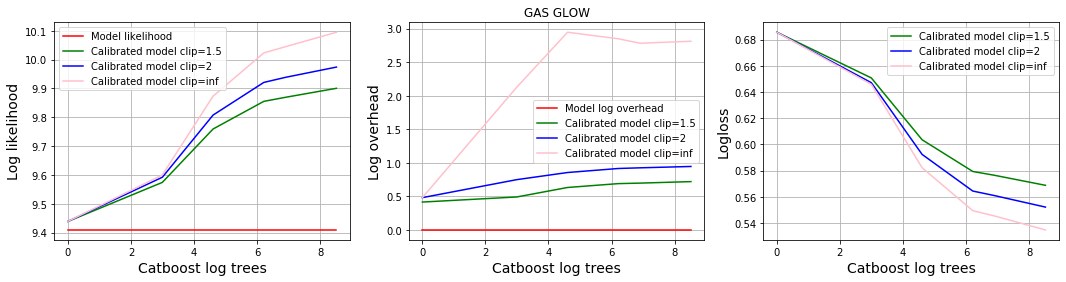

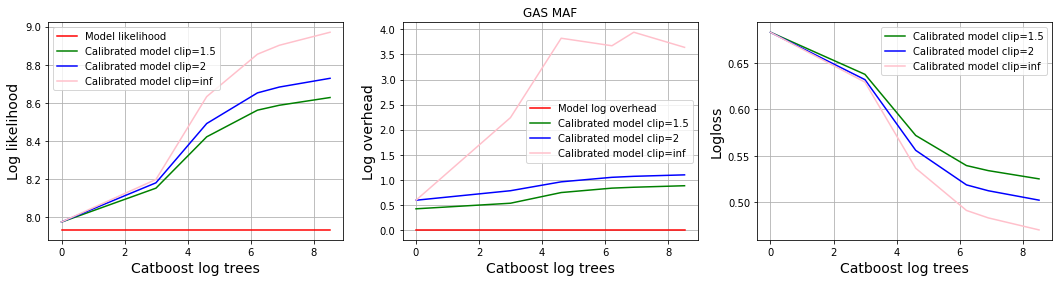

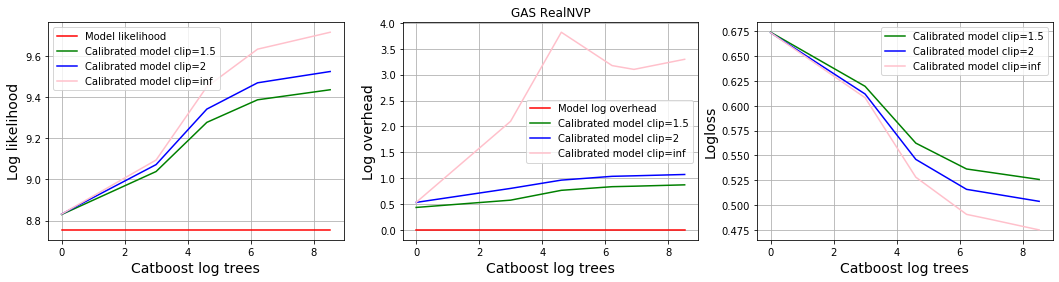

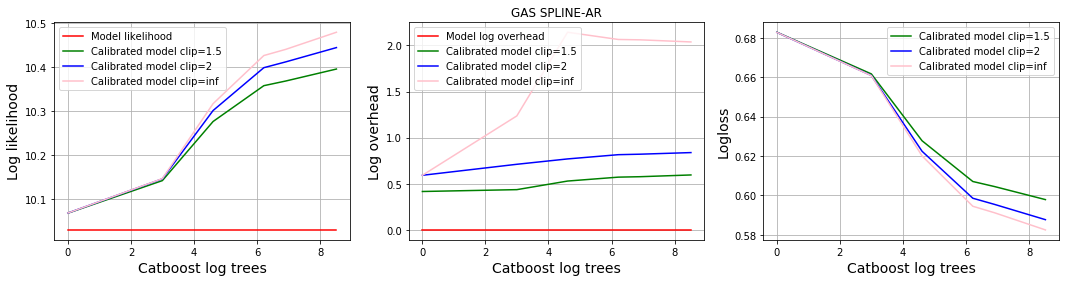

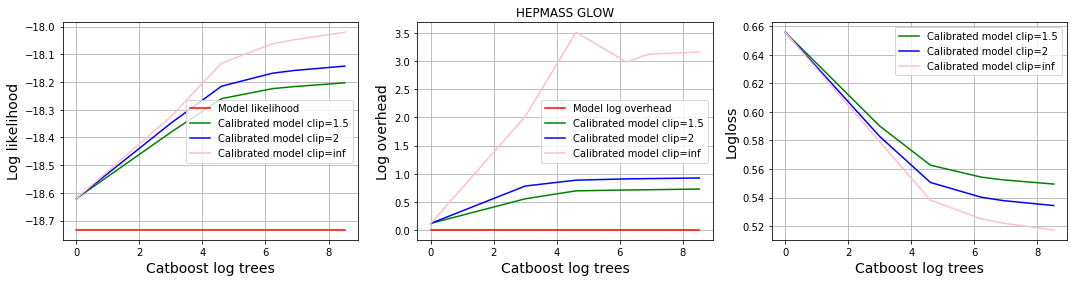

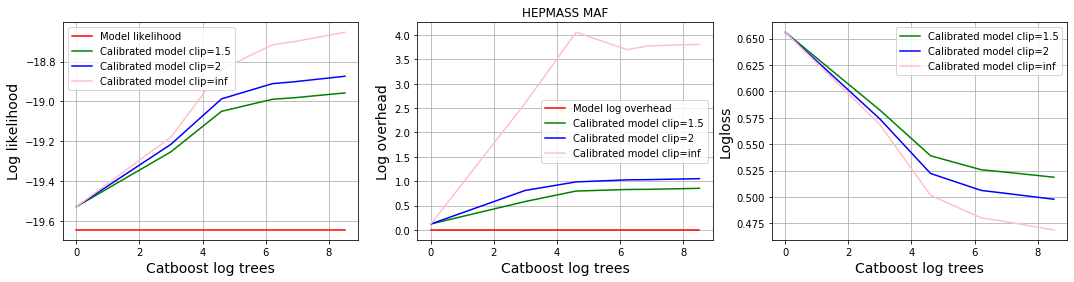

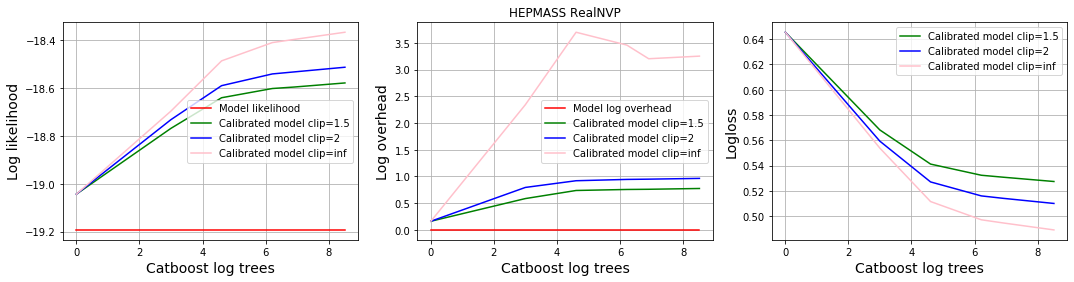

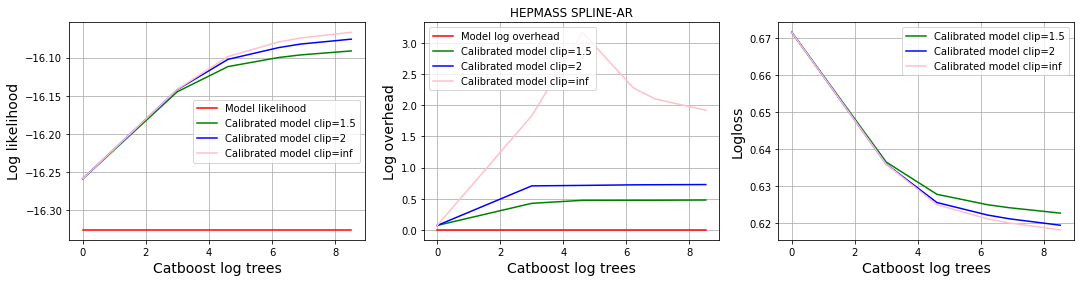

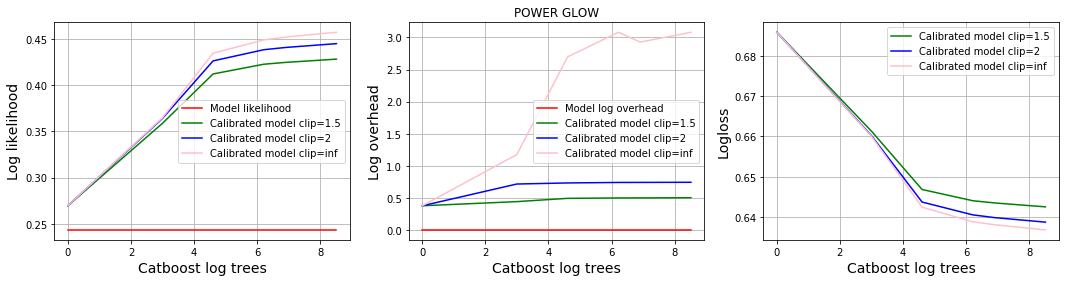

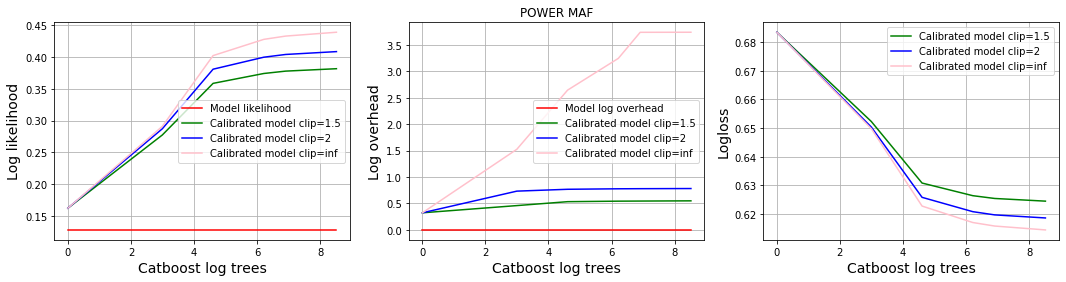

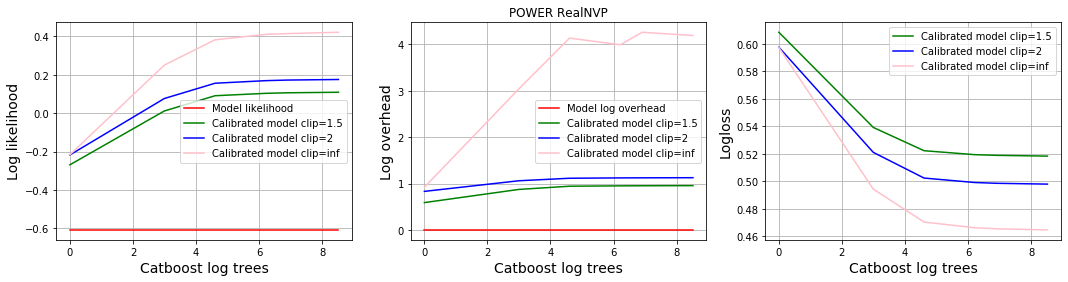

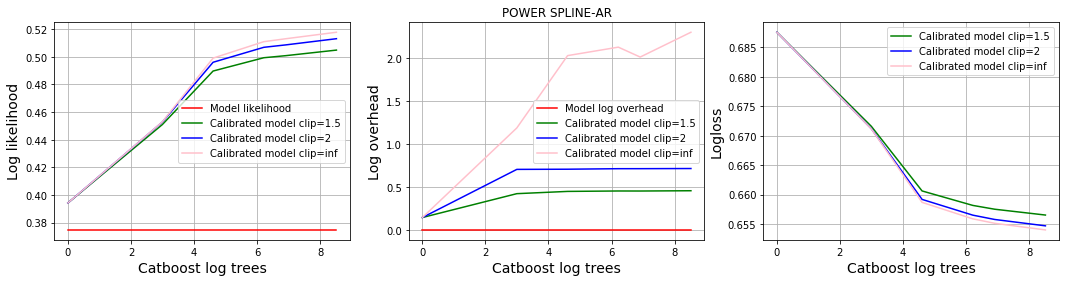

In [29]:
! mkdir plots
for data_name in ('MINIBOONE', 'BSDS300', 'GAS', 'HEPMASS', 'POWER'):
    for model_type in ('GLOW', 'MAF', 'RealNVP', 'SPLINE-AR'):
        iters = np.array([x for x in metrics[(data_name, 'll')][model_type]['calibrated'].index.levels[0] if isinstance(x, int)])
        log_iters = np.log(iters)
        
        fig, axs = plt.subplots(1, 3, figsize=(18, 4))

        nf_ll = metrics[(data_name, 'll')][model_type]['normalizing flow']
        axs[0].plot(log_iters, [nf_ll] * len(log_iters), label='Model likelihood', color='red')

        for clip, color in (
            ('1.5', 'green'),
            ('2', 'blue'),
            ('inf', 'pink'),
        ):
            calibrated_lls = [metrics[(data_name, 'll')][model_type]['calibrated'][i][clip] for i in iters]
            axs[0].plot(log_iters, calibrated_lls, label=f'Calibrated model clip={clip}', color=color)

        axs[0].set_xlabel('Catboost log trees', fontsize=14)
        axs[0].set_ylabel('Log likelihood', fontsize=14)
        axs[0].legend()
        axs[0].grid()


        axs[1].plot(log_iters, [0] * len(log_iters), label='Model log overhead', color='red')

        for clip, color in (
            ('1.5', 'green'),
            ('2', 'blue'),
            ('inf', 'pink'),
        ):
            calibrated_overheads = [metrics[(data_name, 'log overhead')][model_type]['calibrated'][i][clip] for i in iters]
            axs[1].plot(np.log(iters), calibrated_overheads, label=f'Calibrated model clip={clip}', color=color)

        axs[1].set_xlabel('Catboost log trees', fontsize=14)
        axs[1].set_ylabel('Log overhead', fontsize=14)
        axs[1].legend()
        axs[1].grid()


        for clip, color in (
            ('1.5', 'green'),
            ('2', 'blue'),
            ('inf', 'pink'),
        ):
            calibrated_logloss = [metrics[(data_name, 'Logloss')][model_type]['calibrated'][i][clip] for i in iters]
            axs[2].plot(np.log(iters), calibrated_logloss, label=f'Calibrated model clip={clip}', color=color)

        axs[2].set_xlabel('Catboost log trees', fontsize=14)
        axs[2].set_ylabel('Logloss', fontsize=14)
        axs[2].legend()
        axs[2].grid()
        
        axs[1].set_title(f'{data_name} {model_type}')
        
        plt.savefig(f'plots/{data_name}_{model_type}.png')

In [28]:
! ls plots

BSDS300_GLOW.png       GAS_SPLINE-AR.png      MINIBOONE_RealNVP.png
BSDS300_MAF.png        HEPMASS_GLOW.png       MINIBOONE_SPLINE-AR.png
BSDS300_RealNVP.png    HEPMASS_MAF.png	      POWER_GLOW.png
BSDS300_SPLINE-AR.png  HEPMASS_RealNVP.png    POWER_MAF.png
GAS_GLOW.png	       HEPMASS_SPLINE-AR.png  POWER_RealNVP.png
GAS_MAF.png	       MINIBOONE_GLOW.png     POWER_SPLINE-AR.png
GAS_RealNVP.png        MINIBOONE_MAF.png
